In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns

In [2]:
tempos = ["010", "020", "030"]
#temposExp = ["399"]
seeds = ["10", "20"]
quantidadeIperfs = 2500
salvarGraficos = False
#0.10 ini=100 fim=250
#0.20 ini=150 fim=300
#0.30 ini=200 fim=350
intervalosEstaveis = [("010", 100, 250), ("020", 150, 300), ("030", 200, 350)]

In [64]:
#Lendo os arquivos info (report do controlador)
dfPI_info = pd.DataFrame()
dfSW_info = pd.DataFrame()
i = 1
for seed in seeds:
    for tempo in tempos:
        dfPI_infoTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_pi"+(tempo)+"/info_parimpar.txt", sep=" ")
        dfPI_infoTemp['TempoChegada'] = tempo
        dfPI_infoTemp['Seed'] = seed
        dfPI_infoTemp['Metodo'] = 'Estático'
        dfPI_info = pd.concat([dfPI_info, dfPI_infoTemp], ignore_index=True)
        dfSW_infoTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_sw"+(tempo)+"/info_sw.txt", sep=" ")
        dfSW_infoTemp['TempoChegada'] = tempo
        dfSW_infoTemp['Seed'] = seed
        dfSW_infoTemp['Metodo'] = 'Dinâmico'
        dfSW_infoTemp.rename(columns={'VezesBloqueado':'RegrasBloqueadas'}, inplace=True)
        dfSW_info = pd.concat([dfSW_info, dfSW_infoTemp], ignore_index=True)
    i += 1
dfTotal_info = pd.concat([dfPI_info, dfSW_info], ignore_index=True)

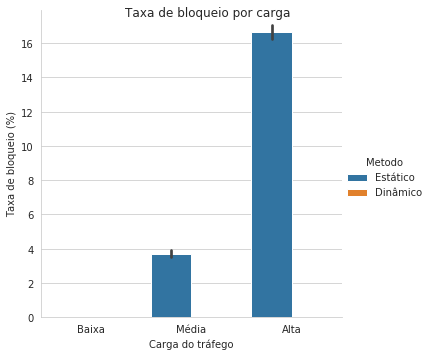

In [66]:
#Grafico de bloqueados metodo par impar
gpb = dfTotal_info.groupby(["Seed", "TempoChegada", "Metodo"]).max()
gpb.reset_index(inplace=True)
gpb["TaxaBloqueio"] = gpb["RegrasBloqueadas"]/2/float(quantidadeIperfs)*100
sns.set_style("whitegrid")
sns_plt = sns.catplot(x="TempoChegada", y="TaxaBloqueio", kind="bar", hue="Metodo", hue_order=["Estático", "Dinâmico"],order=["030", "020", "010"], ci=95, data=gpb)
sns_plt.fig.suptitle('Taxa de bloqueio por carga')
sns_plt.set_axis_labels("Carga do tráfego", "Taxa de bloqueio (%)").set_xticklabels(["Baixa", "Média", "Alta"])
if (salvarGraficos):
    sns_plt.savefig("taxaBloqueio.pdf")

In [5]:
#Lendo todos os CSVs dos iperfs
dfPI_csv = pd.DataFrame()
dfSW_csv = pd.DataFrame()
i = 1
for seed in seeds:
    for tempo in tempos:
        dfPI_csvTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_pi"+(tempo)+"/teste"+(str(i))+"_pi"+(tempo)+".csv")
        dfPI_csvTemp['TempoChegada'] = tempo
        dfPI_csvTemp['Seed'] = seed
        dfPI_csvTemp['Metodo'] = 'PI'
        dfPI_csv = pd.concat([dfPI_csv, dfPI_csvTemp], ignore_index=True)
        dfSW_csvTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_sw"+(tempo)+"/teste"+(str(i))+"_sw"+(tempo)+".csv")
        dfSW_csvTemp['TempoChegada'] = tempo
        dfSW_csvTemp['Seed'] = seed
        dfSW_csvTemp['Metodo'] = 'SW'
        dfSW_csv = pd.concat([dfSW_csv, dfSW_csvTemp], ignore_index=True)
    i += 1
del dfPI_csv['?']
del dfSW_csv['?']
del dfSW_csv['Timestamp']
del dfPI_csv['Timestamp']
dfServerPI = dfPI_csv[dfPI_csv.IpOri == '10.1.0.1']
dfServerSW = dfSW_csv[dfSW_csv.IpOri == '10.1.0.1']
dfServer = pd.concat([dfServerPI, dfServerSW], ignore_index=True)

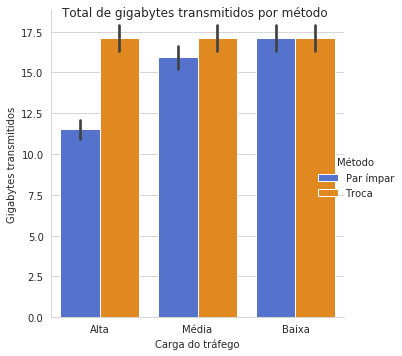

In [6]:
#Trafego total em cada metodo
gpb = dfServer.groupby(["Metodo","TempoChegada", "Seed"]).sum()
gpb["GBEnv"] = gpb["BytesEnv"]/1e9
gpb.reset_index(inplace=True)
sns.set_style("whitegrid")
sns_plt = sns.catplot(legend=True, x="TempoChegada", y="GBEnv", kind="bar", ci=95, data=gpb, hue="Metodo", palette=sns.color_palette(['royalblue', 'darkorange']))
sns_plt.fig.suptitle('Total de gigabytes transmitidos por método')
sns_plt.set_axis_labels("Carga do tráfego", "Gigabytes transmitidos").set_xticklabels(["Alta", "Média", "Baixa"])
sns_plt._legend.set_title('Método')
labels = ['Par ímpar', 'Troca']
for t, l in zip(sns_plt._legend.texts, labels): t.set_text(l)
#sns_plt.fig.subplots_adjust(top=0.8,right=0.8)
#sns_plt.ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
if (salvarGraficos):
    sns_plt.savefig("totalgbtransmitidos.pdf")

In [7]:
#Lendo todos os TXTs dos reports do controlador
dfPI_txt = pd.DataFrame()
dfSW_txt = pd.DataFrame()
i = 1
for seed in seeds:
    for tempo in tempos:
        dfPI_txtTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_pi"+(tempo)+"/info_parimpar.txt", sep=" ")
        dfPI_txtTemp['TempoChegada'] = tempo
        dfPI_txtTemp['Seed'] = seed
        dfPI_txtTemp['Metodo'] = 'PI'
        dfPI_txt = pd.concat([dfPI_txt, dfPI_txtTemp], ignore_index=True)
        dfSW_txtTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_sw"+(tempo)+"/info_sw.txt", sep=" ")
        dfSW_txtTemp['TempoChegada'] = tempo
        dfSW_txtTemp['Seed'] = seed
        dfSW_txtTemp['Metodo'] = 'SW'
        dfSW_txt = pd.concat([dfSW_txt, dfSW_txtTemp], ignore_index=True)
    i += 1
del dfSW_txt['VezesBloqueado']
del dfPI_txt['RegrasBloqueadas']
dfTotal = pd.concat([dfPI_txt, dfSW_txt], ignore_index=True)

In [41]:
#dfTotal.query("Switch == 'HW'")
dfTotal
#for index, row in dfTotal.iterrows():

,Tempo,Switch,RegrasInstaladas,RegrasAceitas,BytesEnviados,TempoChegada,Seed,Metodo
0,8,SW,24,24,0,010,10,PI
1,8,HW,24,24,0,010,10,PI
2,13,SW,48,48,0,010,10,PI
3,13,HW,44,44,0,010,10,PI
4,18,SW,78,78,0,010,10,PI
5,18,HW,73,73,0,010,10,PI
6,23,SW,108,108,0,010,10,PI
7,23,HW,101,101,0,010,10,PI
8,28,SW,137,142,524784,010,10,PI
9,28,HW,130,130,0,010,10,PI


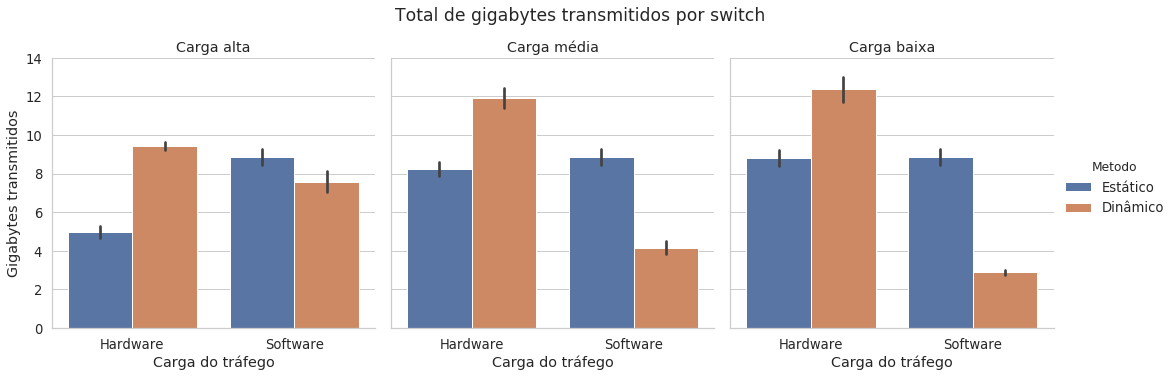

In [92]:
#Trafego em cada switch
gpb = dfTotal.groupby(["Metodo", "TempoChegada", "Seed", "Switch"]).max()
sns.set(font_scale=1.2, style="whitegrid")
#sns.set_style("whitegrid")
gpb["GBEnv"] = gpb["BytesEnviados"]/1e9
gpb.reset_index(inplace=True)
gpb["Metodo"] = gpb["Metodo"].map({"PI": "Estático", "SW": "Dinâmico"})
gpb["NomeSwitch"] = gpb["Switch"].map({"SW": "Software", "HW": "Hardware"})
gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "alta", "020": "média", "030": "baixa"})
sns_plt = sns.catplot(x="NomeSwitch", y="GBEnv", kind="bar", ci=95, data=gpb, col="NomeTempo", hue="Metodo")
#sns_plt = sns.catplot(x="TempoChegada", y="GBEnv", kind="bar", ci=95, data=gpb, col="NomeSwitch", hue="Metodo")
sns_plt.set(ylim=(0, 14))
sns_plt.fig.suptitle('Total de gigabytes transmitidos por switch', y=1.05)
sns_plt.set_axis_labels("Carga do tráfego", "Gigabytes transmitidos")
sns_plt.set_titles("Carga {col_name}")
if (salvarGraficos):
    sns_plt.savefig("totalgbporswitch.pdf")

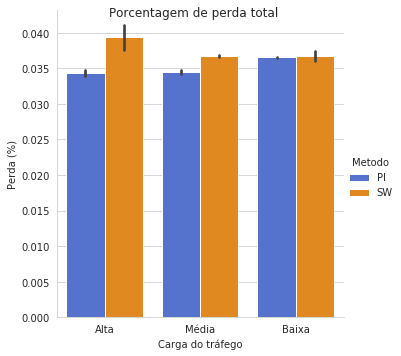

In [9]:
#Perda de pacotes total
gpb = dfServer.groupby(["Metodo", "TempoChegada", "Seed"]).sum()
gpb["PPerda"] = (gpb["PctPerdido"]/gpb["PctEnv"])*100
gpb
gpb.reset_index(inplace=True)
sns.set_style("whitegrid")
sns_plt = sns.catplot(x="TempoChegada", y="PPerda", kind="bar", ci=95, data=gpb, hue="Metodo", palette=sns.color_palette(['royalblue', 'darkorange']))
sns_plt.fig.suptitle('Porcentagem de perda total')
sns_plt.set_axis_labels("Carga do tráfego", "Perda (%)").set_xticklabels(["Alta", "Média", "Baixa"])
if (salvarGraficos):
    sns_plt.savefig("totalPerda.pdf")

In [10]:
#Pegando portas no intervalo estavel
dfIperf = pd.DataFrame()
for i in range(len(seeds)):
    dfIperf_temp = pd.read_csv("../Saidas/teste"+(str(i+1))+"_pi010/iperfs.txt", sep="\t")
    dfIperf_temp['Seed'] = seeds[i]
    dfIperf = pd.concat([dfIperf, dfIperf_temp], ignore_index=True)
portasEstaveis010 = []
portasEstaveis020 = []
portasEstaveis030 = []
for a, b, c in intervalosEstaveis:
    for index, row in dfIperf.iterrows():
        if (row['Inicio(seg)'] >= b and row['Inicio(seg)'] <= c):
            if (a == "010"):
                portasEstaveis010.append(int(row['PCli']))
            elif (a == "020"):
                portasEstaveis020.append(int(row['PCli']))
            elif (a == "030"):
                portasEstaveis030.append(int(row['PCli']))

In [11]:
gpb = dfServer.groupby(["Metodo", "PortaOri", "PortaDest", "TempoChegada"]).mean()
gpb.reset_index(inplace=True)
dfEstavel = gpb
for index, row in gpb.iterrows():
    if (not(int(row['PortaDest']) in portasEstaveis010 and row['TempoChegada'] == "010")):
        dfEstavel.drop(index)
    elif (not(int(row['PortaDest']) in portasEstaveis020 and row['TempoChegada'] == "020")):
        dfEstavel.drop(index)
    elif (not(int(row['PortaDest']) in portasEstaveis030 and row['TempoChegada'] == "030")):
        dfEstavel.drop(index)

In [34]:
#Gráfico de vazão no período estável
gpb = dfTotal.groupby(["TempoChegada", "Switch", "Tempo"]).mean()
gpb.reset_index(inplace=True)
for index, row in gpb.iterrows():
    for a, b, c in intervalosEstaveis:
        if (row["TempoChegada"] == a and (row['Tempo'] <= b or row['Tempo'] >= c)):
            gpb.drop(index, inplace=True)
#gpb.reset_index(inplace=True)
#del gpb["index"]
#gpb = gpb.groupby(['TempoChegada', 'Switch'])
#gpb.head(9999)

In [36]:
gpb

,TempoChegada,Switch,Tempo,RegrasInstaladas,RegrasAceitas,BytesEnviados
61,010,HW,102,187.0,387.0,6.371704e+08
62,010,HW,104,200.0,378.0,5.294359e+08
63,010,HW,105,179.5,403.5,6.216936e+08
64,010,HW,107,170.0,387.0,7.792379e+08
65,010,HW,109,198.0,402.0,6.308109e+08
66,010,HW,110,192.5,438.5,7.432826e+08
67,010,HW,112,187.0,424.0,9.253002e+08
68,010,HW,114,196.0,424.0,7.463791e+08
69,010,HW,115,186.5,443.0,8.152439e+08
70,010,HW,117,170.0,424.0,1.076193e+09


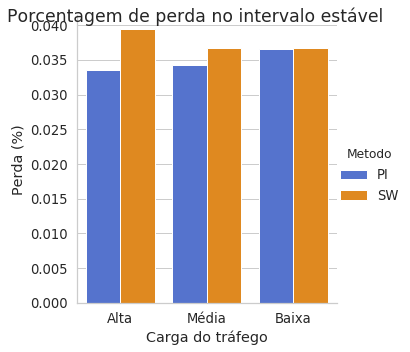

In [93]:
#Perda de pacotes no intervalo estavel
gpb = dfEstavel.groupby(["Metodo", "TempoChegada"]).sum()
gpb["PPerda"] = (gpb["PctPerdido"]/gpb["PctEnv"])*100
gpb.reset_index(inplace=True)
sns.set_style("whitegrid")
sns_plt = sns.catplot(x="TempoChegada", y="PPerda", kind="bar", ci=99.999, data=gpb, hue="Metodo", palette=sns.color_palette(['royalblue', 'darkorange']))
sns_plt.fig.suptitle('Porcentagem de perda no intervalo estável')
sns_plt.set_axis_labels("Carga do tráfego", "Perda (%)").set_xticklabels(["Alta", "Média", "Baixa"])
if (salvarGraficos):
    sns_plt.savefig("perdaEstavel.pdf")

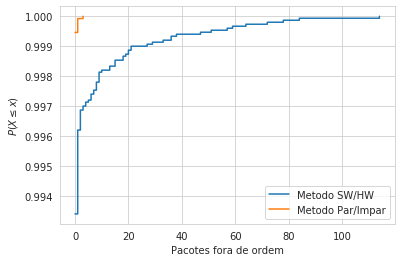

In [14]:
#CDF dos pacotes fora de ordem --- NÃO DIVIDE POR SEED
a = dfServerSW['ForaOrdem'].tolist()
b = dfServerPI['ForaOrdem'].tolist()
x = np.sort(a)
x1 = np.sort(b)
ecdf = sm.distributions.ECDF(a)
ecdf1 = sm.distributions.ECDF(b)
y = ecdf(x)
y1 = ecdf1(x1)
plt.step(x, y, where='post', label="Metodo SW/HW")
plt.step(x1, y1, where='post', label="Metodo Par/Impar")
plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Pacotes fora de ordem')
plt.legend()
if (False):
    plt.savefig('foraOrdem.pdf')
plt.show()